### Importing Tools:

In [1]:
import random
import os
import sys
import warnings
import datetime
import time


# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.signal as sc
from scipy.signal import butter, filtfilt

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

#### Input Parameters

In [32]:
## Input File Location:
path_in= 'D:/Thesis/Github/Neural Network/' 
file_in = 'Segy_Data/IRP1909132tlaa.P_s1_c5_LC.sgy'


#file_in = 'COR_data.h5'
## Total Gather - 482 * 636
## Time samples

## For CNN sliding 
train_start_gather = 0
train_end_gather = 100
val_start_gather = 100
val_end_gather = 120
test_start_gather = 120
test_end_gather = 125
out_x,out_y  = 64,256
factor_x,factor_y = 4,4
part_x,part_y =2,2
tot_x,tot_y =635,1600
inn_x,inn_y = int(out_x/factor_x),int(out_y/factor_y)

## Filter function
f_low1 = 20
f_high1= 25
f_low2 = 50
f_high2= 55
f_low3 = 80
f_high3= 85 

num_epochs = 50

dt = 0.004
fs=1/dt

## Genertaing Training Data Sets

dropout = 0.4
BatchSize = 30
ValidationSplit = 0.2


path_out= 'D:/Thesis/Github/Reults/' 
file_out = 'Pytorch_E50_2Bands'



output_csv = 'D:\\Thesis\\Github\\Neural Network\\Trained Models\\Pytorch\\Pytorch_E50_2Bands_errors.csv'

output_model = 'D:\\Thesis\\Github\\Neural Network\\Trained Models\\Pytorch\\Pytorch_E50_2Bands_model.pth'

output_predicted = 'D:\\Thesis\\Github\\Neural Network\\Trained Models\\Pytorch\\Pytorch_E50_2Bands_predicted.h5'

import torch
import torch.nn as nn


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available.")

print("Selected device:", device)





GPU is not available.
Selected device: cpu


In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs):
    # Normalize the frequencies
    f_stop1 = lowcut  # Hz
    f_stop2 = highcut # Hz
    fs_normalized = fs  # Hz (Nyquist frequency)
    order = 4

    # Compute the filter coefficients
    b, a = scipy.signal.bessel(order,  [f_stop1 / fs_normalized, f_stop2 / fs_normalized], btype='band')

    # Apply the filter to the data
    filtered_data = scipy.signal.filtfilt(b, a, data)

    return filtered_data

def butter_bandstop_filter(signal,f_low,f_high,fs):

    # Define the filter parameters
    f_stop1 = f_low  # Hz
    f_stop2 = f_high # Hz
    fs_normalized = fs  # Hz (Nyquist frequency)
    order = 4

    # Compute the filter coefficients
    b, a = scipy.signal.bessel(order, [f_stop1 / fs_normalized, f_stop2 / fs_normalized], btype='bandstop')

    # Apply the filter to the input signal
    filtered_signal = sc.filtfilt(b, a, signal)

    return filtered_signal




In [5]:
def Generate_training_set_sgy(path,filename,out_x,out_y,factor_x,factor_y,part_x,part_y,tot_x,tot_y,gather_start,gather_end,fs):
#Parameter:
    ## Out_x and out_y: defines the outer window size
    ## factor_x and _y: defines the factor by which outer window is related to the inner window
    ## part_x and part_y: defines the part of the outer window from where the inner window starts
    ## tot_x and tot_y: defines the size of the gather (needs to be a mulitple of the outer window: to store them in same size windows for CNN training)
    ## gather: - input gather
    ## num_gather: - Number of input gathers, which could be different for training and test data sets. 
    ## Return: Stored all inner (non overlaped) and outer windows (overlaped)
#Defining a sliding_window_2d: 
    # An overlapping outer window is moved across the gather.
        ## An inner window of fixed size is defined as a part of the outer window which does not overlap. 
        ## 
    # Factor (in x or y)- divides the outer window into equal parts out of which one part of the outer window forms the inner window.
    # Part (in x or y) - defines the part of the outer window which forms the inner window starts (eg: if 1 -inner window at starting, 2 = starts with after one overlap)  
    # (for eq: Part = 2) Outer Window includes one part from the gather followed by one part which is the inner window (non overlapping) and remianing parts of gathers
# Exceptions: 
    # When the outer window is at the starting edge, the inner window slides from the starting (0-cordinates) to the defined part. 
    # After reaching the defined part, the outer windows with fixed inner parts moves with ovelapping (inner windows do not overlap). 
    # Finally, the outer window is at the end egde and inner window is at the defined part of the outer window, leaving some part of the gather. 
    # Keeping the outer window fixed the inner window slides from the defined part to the end edge, covering the whole gather without overlaping and as a part of the outer window. 


    ## Inner window size with overlaping of size of inner windows, as the inner window is not overlapping
    inn_x,inn_y = int(out_x/factor_x),int(out_y/factor_y)

    overlap_x,overlap_y = inn_x,inn_y

    num_windows_x,num_windows_y= int(np.ceil(tot_x/inn_x)), int(np.ceil(tot_y/inn_y))
    num_windows =  num_windows_x*num_windows_y 
    num_gathers = gather_end - gather_start 
    ## Return Windows
    OUT_windows = np.zeros((num_gathers*num_windows,1,out_x,out_y))
    OUT_windows_filtered = np.zeros((num_gathers*num_windows,1,out_x,out_y))
    OUT_windows_filtered_noised = np.zeros((num_gathers*num_windows,1,out_x,out_y))
    

    normfac =[]
    
   
    with segyio.open(path + filename, ignore_geometry=True) as f:
        count =0
    
        for k in tqdm (np.arange(gather_start,gather_end,1)):
            gather = f.trace.raw[:][k+k*(tot_x):k+(k+1)*(tot_x),0:tot_y]
            
            gather_filtered = butter_bandstop_filter(gather,20,25,fs)
            gather_filtered = butter_bandstop_filter(gather_filtered,50,55,fs)

            for i in range (0,tot_x,inn_x):  ## Loop over traces - x direction
                ## Outer Window - X direction
                ox_s = int(np.min([np.max([0,i-part_x*overlap_x]),tot_x])) #int(np.min([np.max([0,i-overlap_x]),tot_x]))
                ox_e =   ox_s + out_x
                if ox_e > tot_x:
                    ox_s = tot_x -out_x
                    ox_e = tot_x
                for j in range (0,tot_y,inn_y):  ## Loop over traces - x direction
                    ## Outer Window - X direction
                    oy_s = int(np.min([np.max([0,j-part_y*overlap_y]),tot_y])) #int(np.min([np.max([0,i-overlap_x]),tot_x]))
                    oy_e =   oy_s + out_y
                    if oy_e > tot_y:
                        oy_s = tot_y -out_y
                        oy_e = tot_y

                    ## All filters applt to the outer window:
                    # Orignal Winwdows
                    outer_window = gather[ox_s:ox_e,oy_s:oy_e]
                    outer_window_filtered = gather_filtered[ox_s:ox_e,oy_s:oy_e]
                    outer_window_filtered_noised = gather_filtered[ox_s:ox_e,oy_s:oy_e]
                    # Adding Band Limited Noise:
                    noisefac = np.mean(np.abs(outer_window_filtered_noised))
                    noise = np.random.uniform(low=-1,high=1,size=(out_x,out_y))*noisefac*0.02
                    noise_filtered1 = butter_bandpass_filter(noise,20,25,fs)
                    noise_filtered2= butter_bandpass_filter(noise,50,55,fs)
                    outer_window_filtered_noised = outer_window_filtered_noised + noise_filtered1 +noise_filtered2

                    # Normailizing factors. 
                    normalized = np.max(np.abs(outer_window))
                    normfac.append(normalized)

                    # Target windows
                    outer_window_normalized= ((outer_window/normalized)+1)/2
                    outer_window_filtered_normalized= ((outer_window_filtered/normalized)+1)/2
                    outer_window_filtered_noised_normalized= ((outer_window_filtered_noised/normalized)+1)/2
                    # Storing Window
                    OUT_windows[count] = outer_window_normalized.reshape((1,out_x,out_y))
                    #OUT_windows_filtered[count] = outer_window_filtered_normalized.reshape((1,out_x,out_y))
                    OUT_windows_filtered_noised[count]= outer_window_filtered_noised_normalized.reshape((1,out_x,out_y))


                    count =count+1                
    return(OUT_windows,OUT_windows_filtered_noised,normfac)

def retreive_gather(Out_windows,normfac,factor_x,factor_y,tot_x, tot_y, inn_x,inn_y,part_x,part_y):
    ## retriving the image back:
    Original= np.zeros((tot_x,tot_y))
    
    count = 0
    for i in range (0,tot_x,inn_x):
        if i <= part_x*inn_x:
            x_s = i
        if i > part_x*inn_x:
            x_s = part_x*inn_x
        if i >= tot_x - (factor_x-part_x)*inn_x:
            x_s = int((factor_x - np.ceil((tot_x-i)/inn_x))*inn_x)
        x_e = x_s +inn_x

        for j in range (0,tot_y,inn_y):
            if j <= part_y*inn_y:
                y_s = j
            if j > part_y*inn_y:
                y_s = part_y*inn_y
            if j >= tot_y - (factor_y-part_y)*inn_y:
                y_s = int((factor_y - np.ceil((tot_y-j)/inn_y))*inn_y)
            y_e = y_s + inn_y

            a = Out_windows[count,:,x_s:x_e,y_s:y_e].reshape((inn_x,inn_y))

            
            a = ((a*2)-1)*normfac[count]
            
            ox_s = i
            ox_e = i+inn_x
            if ox_e > tot_x:
                ox_s = tot_x -inn_x
                ox_e = tot_x 
            oy_s = j
            oy_e = j+inn_y
            if oy_e > tot_y:
                oy_s = tot_y -inn_y
                oy_e = tot_y 

            Original[ox_s:ox_e,oy_s:oy_e] = a
            count = count+1
    
    return Original

### Test Data Set

In [9]:
TE,TE_filtered_noised,normfac_te= Generate_training_set_sgy(path_in,file_in,out_x,out_y,factor_x,factor_y,part_x,part_y,tot_x,tot_y,test_start_gather,test_end_gather,fs)
te_inputs =torch.from_numpy(TE_filtered_noised)
te_inputs = te_inputs.to(torch.float64)


te_labels = torch.from_numpy(TE)
te_labels = te_labels.to(torch.float)

te_dataset = TensorDataset(te_inputs,te_labels)
batch_size =32
te_loader = DataLoader(te_dataset,batch_size,shuffle=False)

100%|██████████| 5/5 [00:29<00:00,  5.98s/it]


## Defined U-net

In [10]:
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs.float())  # Convert the input tensor to float
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs
def calculate_accuracy(outputs, labels):
    predictions = torch.argmax(outputs, dim=1)
    correct = torch.sum(predictions == labels).item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy


## Load The correct Model

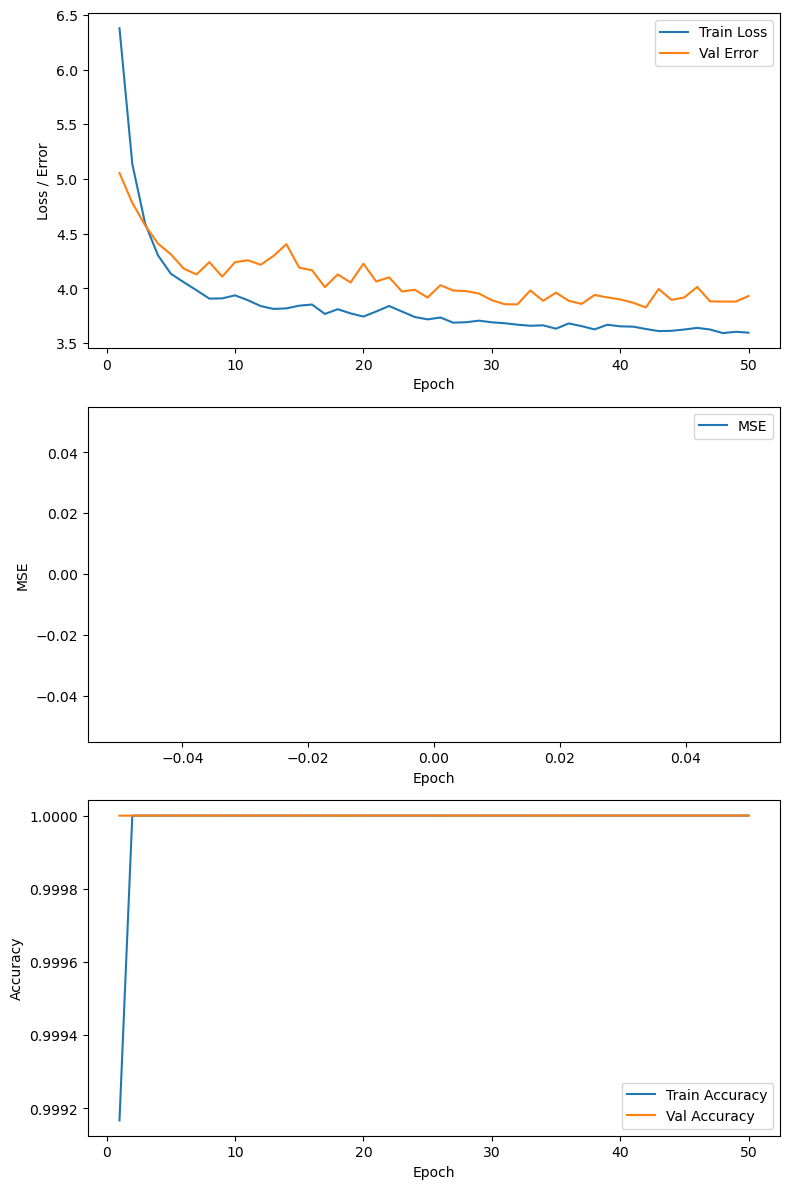

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file = os.path.join(output_csv)  
data = pd.read_csv(csv_file)

# Extract the values from the loaded data
train_losses = data['Train Loss']
val_errors = data['Val Error']
train_accuracy = data['Train Accurary']
val_accuracy = data['Val Accuracy']
mse_values = data['MSE']

import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1: Train Loss and Val Error
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
axs[0].plot(range(1, len(val_errors) + 1), val_errors, label='Val Error')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss / Error')
axs[0].legend()

# Plot 2: MSE Values
axs[1].plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE')
axs[1].legend()

# Plot 3: Train Accuracy and Val Accuracy
axs[2].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
axs[2].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Val Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [27]:
model = build_unet()
# Load the state dictionary into the model
model.load_state_dict(torch.load(output_model, map_location=torch.device('cpu')))

# Move the model to the desired device
model = model.to(device)

with torch.no_grad():
    predictions = []
    for te_inputs, _ in te_loader:
        te_inputs = te_inputs.to(device)
        outputs = model(te_inputs)
        predictions.append(outputs.cpu())
predictions = torch.cat(predictions, dim=0)


TE_filtered_noised_list = []
TE_list = []

for batch in te_loader:
    TE_filtered_noised, TE = batch
    
    TE_filtered_noised_list.append(TE_filtered_noised)
    TE_list.append(TE)

# Concatenate the list of tensors into a single tensor
Filt_ret= torch.cat(TE_filtered_noised_list)
TE_ret = torch.cat(TE_list)


Pred = retreive_gather(predictions, normfac_te, factor_x, factor_y, tot_x, tot_y, inn_x, inn_y, part_x, part_y)
OG = retreive_gather(TE_ret,normfac_te,factor_x,factor_y,tot_x, tot_y, inn_x,inn_y,part_x,part_y)
OG_filt= retreive_gather(Filt_ret,normfac_te,factor_x,factor_y,tot_x, tot_y, inn_x,inn_y,part_x,part_y)

Original_rfft2 = np.abs(np.fft.rfft2(OG))
filtered_rfft2 = np.abs(np.fft.rfft2(OG_filt))
Predicted_rfft2 = np.abs(np.fft.rfft2(Pred))

Original_rfft = np.abs(np.fft.rfft(OG))
filtered_rfft = np.abs(np.fft.rfft(OG_filt))
Predicted_rfft = np.abs(np.fft.rfft(Pred))



## Saving Predictions


In [34]:
import h5py

# Create an HDF5 file
output_pred = output_predicted
with h5py.File(output_pred, 'w') as hf:
    # Create datasets in the HDF5 file and write the arrays
    hf.create_dataset('Predicted_E50_2bands', data=Pred)
    
print(f"The arrays have been saved in the file: {output_pred}")

'''output_once = 'D:\\Thesis\\Github\\Neural Network\\Trained Models\\Pytorch\\TE_SEGY_5.h5'
with h5py.File(output_once, 'w') as hf:
    hf.create_dataset('TE_SEGY_5G', data=OG)
    hf.create_dataset('TE-Filtered_SEGY_5G', data=OG_filt)'''
   


The arrays have been saved in the file: D:\Thesis\Github\Neural Network\Trained Models\Pytorch\Pytorch_E50_2Bands_predicted.h5


# QC

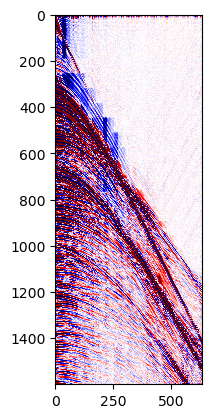

In [36]:
file = output_predicted  # Specify the path to your HDF5 file
with h5py.File(file, 'r') as hf:
    # Access the 'Pred' dataset
    dataset = hf['Predicted_E50_2bands']

    # Read the data from the dataset
    Pred = dataset[:]



The MAE of the input data was: 4.015863257193137
The MAE of the input data was: 0.003613577643149936
The Max Abs Error of the input data was:-388.82421875


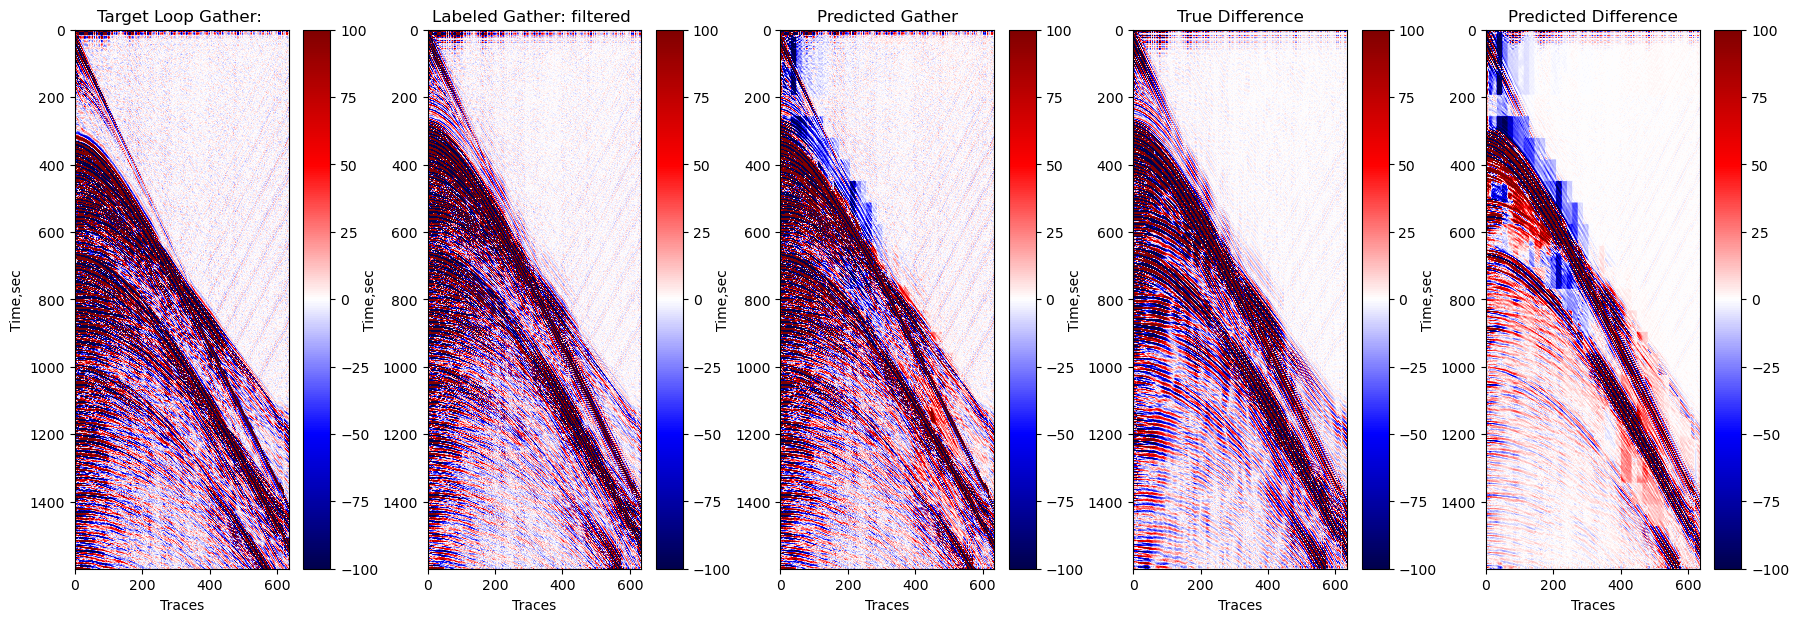

In [31]:
## Predicted Gathers:

plt.figure(figsize=(22,7))
plt.subplot(151)
plt.imshow(OG.T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Target Loop Gather: ')
plt.colorbar()
plt.subplot(152)
plt.imshow((OG_filt).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Labeled Gather: filtered ')
plt.colorbar()
plt.subplot(153)
plt.imshow((Pred).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Gather')
plt.colorbar()
plt.subplot(154)
plt.imshow((OG - OG_filt).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('True Difference')
plt.colorbar()
plt.subplot(155)
plt.imshow((Pred - OG_filt).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Difference')
plt.colorbar()
print('The MAE of the input data was: ' + str(np.abs(np.mean(OG-Pred))))
print('The MAE of the input data was: ' + str(np.abs(np.mean(OG_filt-OG))))
print('The Max Abs Error of the input data was:' + str((np.max(OG))-np.max(Pred)))

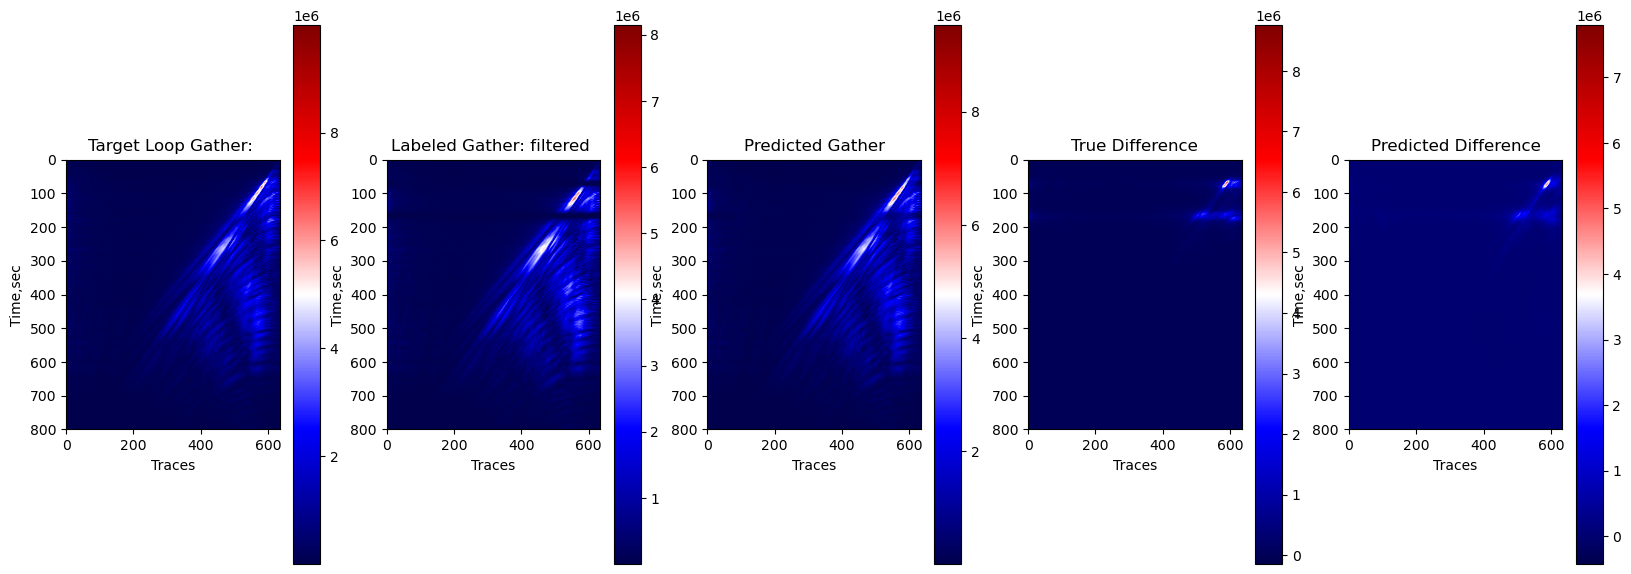

In [29]:
plt.figure(figsize=(20,7))
plt.subplot(151)
plt.imshow(Original_rfft2.T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Target Loop Gather: ')
plt.colorbar()
plt.subplot(152)
plt.imshow((filtered_rfft2).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Labeled Gather: filtered ')
plt.colorbar()
plt.subplot(153)
plt.imshow((Predicted_rfft2).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Gather')
plt.colorbar()
plt.subplot(154)
plt.imshow((Original_rfft2 - filtered_rfft2).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('True Difference')
plt.colorbar()
plt.subplot(155)
plt.imshow((Predicted_rfft2 - filtered_rfft2).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Difference')
plt.colorbar()




(0.0, 400000.0)

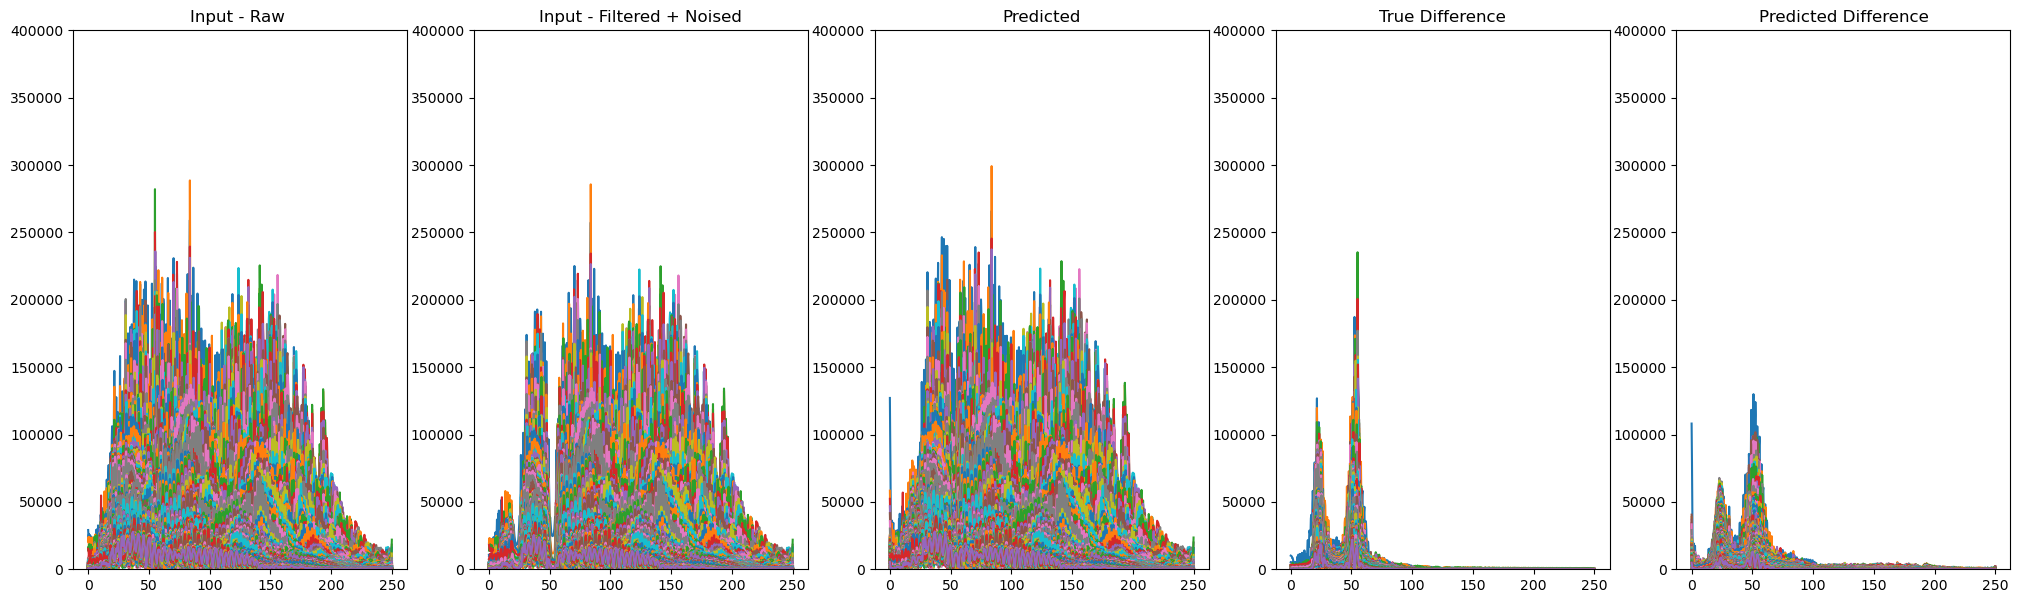

In [30]:
freq = np.linspace(0,250,801)
plt.figure(figsize=(25,7))
plt.subplot(151)
plt.plot(freq,np.abs(Original_rfft.T))
plt.title('Input - Raw ')
plt.ylim(0,400000)
plt.subplot(152)
plt.plot(freq,np.abs(filtered_rfft.T))
plt.title('Input - Filtered + Noised')
plt.ylim(0,400000)
plt.subplot(153)
plt.plot(freq,np.abs(Predicted_rfft.T))
plt.title('Predicted')
plt.ylim(0,400000)
plt.subplot(154)
plt.plot(freq,np.abs(Original_rfft - filtered_rfft).T)
plt.title('True Difference')
plt.ylim(0,400000)
plt.subplot(155)
plt.plot(freq,np.abs(Predicted_rfft - filtered_rfft).T)
plt.title('Predicted Difference')
plt.ylim(0,400000)

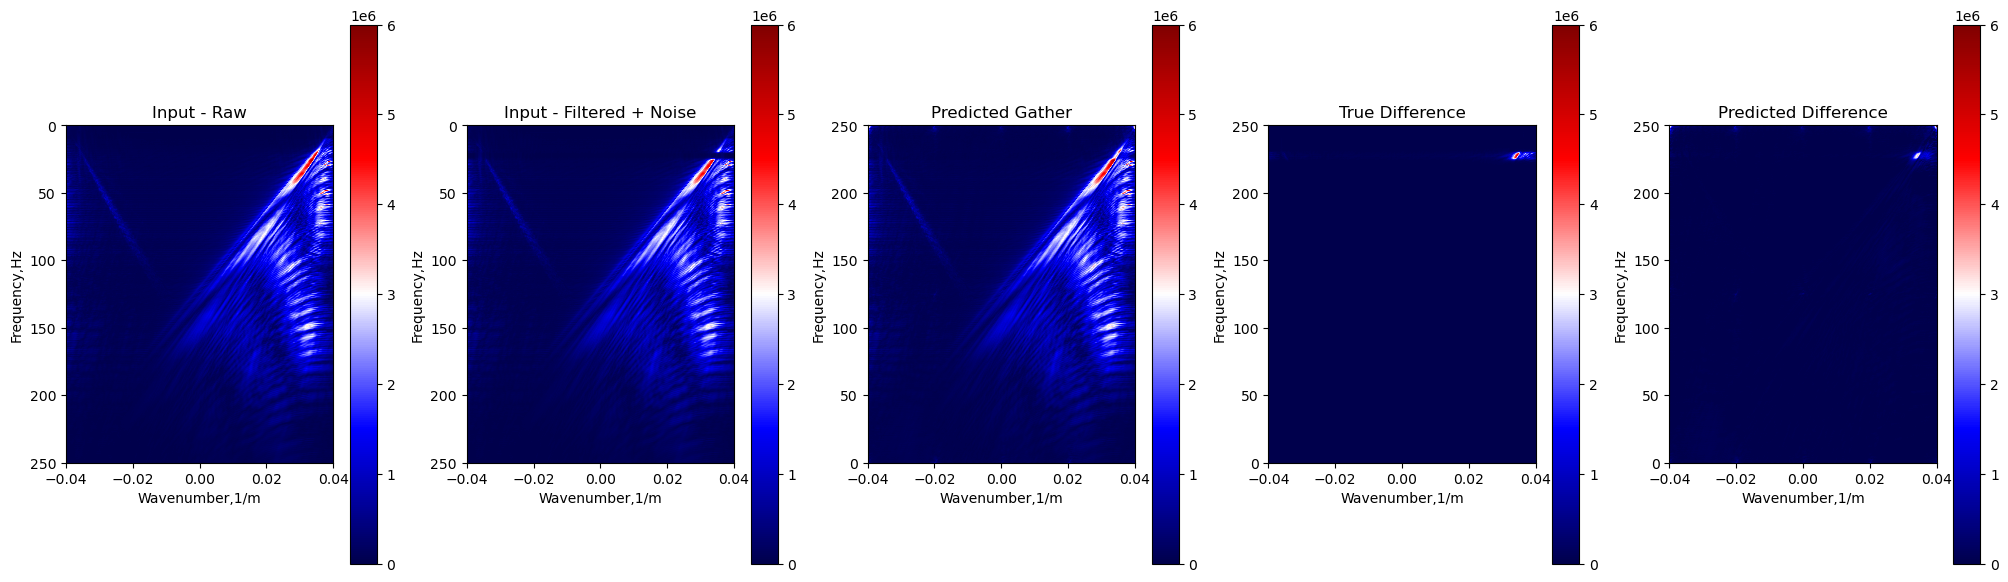

In [34]:

xmin, xmax, ymin, ymax = -0.04, 0.04, 0, 250

# Compute the aspect ratio of the plot
dx = (xmax - xmin) / Original_rfft.shape[0]
dy = (ymax - ymin) / noise_rfft.shape[1] 

aspect = dx/ dy

plt.figure(figsize=(25,7))
plt.subplot(151)
plt.imshow(Original_rfft.T, cmap='seismic',extent=[xmin, xmax, ymax, ymin], aspect=aspect)
plt.xlabel('Wavenumber,1/m')
plt.ylabel('Frequency,Hz')
plt.title('Input - Raw')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(152)
plt.imshow((noise_rfft).T, cmap='seismic',extent=[xmin, xmax, ymax, ymin], aspect=aspect)
plt.xlabel('Wavenumber,1/m')
plt.ylabel('Frequency,Hz')

plt.title('Input - Filtered + Noise')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(153)
plt.imshow((Predicted_rfft).T, cmap='seismic',extent=[xmin, xmax, ymin, ymax], aspect=aspect)
plt.xlabel('Wavenumber,1/m')
plt.ylabel('Frequency,Hz')

plt.title('Predicted Gather')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(154)
plt.imshow((Original_rfft - noise_rfft).T, cmap='seismic',extent=[xmin, xmax, ymin, ymax], aspect=aspect)
plt.xlabel('Wavenumber,1/m')
plt.ylabel('Frequency,Hz')

plt.title('True Difference')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(155)
plt.imshow((Predicted_rfft -noise_rfft).T, cmap='seismic',extent=[xmin, xmax, ymin, ymax], aspect=aspect)
plt.xlabel('Wavenumber,1/m')
plt.ylabel('Frequency,Hz')

plt.title('Predicted Difference')
plt.colorbar()
plt.clim(0,6e6)

